In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_ind, mannwhitneyu

Part A : EDA

In [7]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

In [8]:
print("\nClass distribution:")
print(df["Class"].value_counts())


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


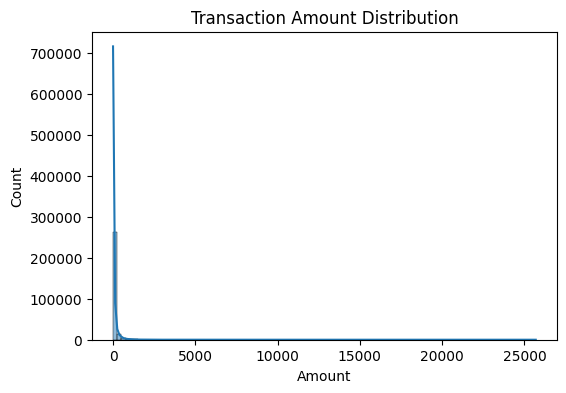

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(df["Amount"], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


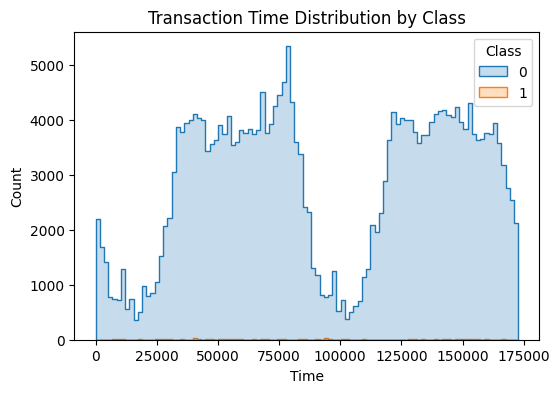

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(df, x="Time", hue="Class", bins=100, element="step")
plt.title("Transaction Time Distribution by Class")
plt.show()

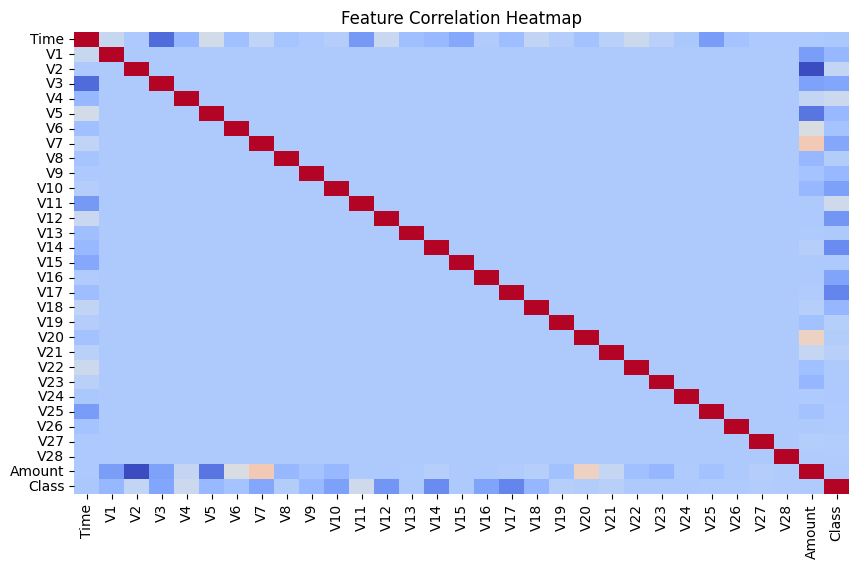

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", cbar=False)
plt.title("Feature Correlation Heatmap")
plt.show()

Part B : Class Imbalance

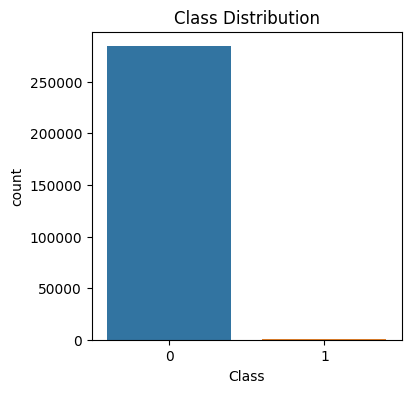

Fraud cases: 0.173% of all transactions


In [12]:
plt.figure(figsize=(4,4))
sns.countplot(x="Class", data=df)
plt.title("Class Distribution")
plt.show()

fraud_pct = (df["Class"].sum() / len(df)) * 100
print(f"Fraud cases: {fraud_pct:.3f}% of all transactions")

Class imbalance can lead to biased predictions, poor performance on the minority class, and misleading evaluation metrics

Part C : Under and over sampling

In [13]:
X = df.drop("Class", axis=1)
y = df["Class"]

#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#combine train into one DF
train_df = pd.concat([X_train, y_train], axis=1)

#separate fraud and non-fraud
fraud = train_df[train_df["Class"] == 1]
nonfraud = train_df[train_df["Class"] == 0]

In [14]:
#Random Under-Sampling
nonfraud_under = nonfraud.sample(len(fraud), random_state=42)
rus_df = pd.concat([fraud, nonfraud_under])
X_rus = rus_df.drop("Class", axis=1)
y_rus = rus_df["Class"]

In [15]:
#Random Over-Sampling
fraud_over = fraud.sample(len(nonfraud), replace=True, random_state=42)
ros_df = pd.concat([fraud_over, nonfraud])
X_ros = ros_df.drop("Class", axis=1)
y_ros = ros_df["Class"]

In [18]:
#model training
def evaluate_model(X_train, y_train, X_test, y_test, method_name):
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== Results using {method_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
evaluate_model(X_train, y_train, X_test, y_test, "Original Imbalanced")

evaluate_model(X_rus, y_rus, X_test, y_test, "Random Under-Sampling")

evaluate_model(X_ros, y_ros, X_test, y_test, "Random Over-Sampling")


=== Results using Original Imbalanced ===
Confusion Matrix:
[[85277    18]
 [   60    88]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9995     85295
           1     0.8302    0.5946    0.6929       148

    accuracy                         0.9991     85443
   macro avg     0.9147    0.7972    0.8462     85443
weighted avg     0.9990    0.9991    0.9990     85443


=== Results using Random Under-Sampling ===
Confusion Matrix:
[[81670  3625]
 [   21   127]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9575    0.9782     85295
           1     0.0338    0.8581    0.0651       148

    accuracy                         0.9573     85443
   macro avg     0.5168    0.9078    0.5216     85443
weighted avg     0.9981    0.9573    0.9766     85443


=== Results using Random Over-Sampling ===
Confusion Matrix:
[[82309  2986]
 [   19   129]]

Classification Rep

Part D : Hypothesis Testing

In [20]:
fraud_all = df[df["Class"]==1]
nonfraud_all = df[df["Class"]==0]

p_values = {}
for col in df.columns[:-1]:  # skip "Class"
    try:
        # Welch's t-test
        t_stat, p_t = ttest_ind(fraud_all[col], nonfraud_all[col], equal_var=False)
        # Mann–Whitney U test
        u_stat, p_u = mannwhitneyu(fraud_all[col], nonfraud_all[col])
        p_values[col] = {"t-test": p_t, "mannwhitney": p_u}
    except Exception:
        continue

significant = {k:v for k,v in p_values.items() if v["t-test"]<0.05 or v["mannwhitney"]<0.05}
print("\nSignificant Features (p < 0.05):")
for feat, vals in significant.items():
    print(f"{feat}: t-test={vals['t-test']:.4e}, mannwhitney={vals['mannwhitney']:.4e}")


Significant Features (p < 0.05):
Time: t-test=1.6546e-10, mannwhitney=4.3862e-10
V1: t-test=5.4916e-45, mannwhitney=1.7408e-113
V2: t-test=1.2886e-59, mannwhitney=1.6504e-163
V3: t-test=4.7861e-75, mannwhitney=1.2110e-219
V4: t-test=4.5873e-136, mannwhitney=3.6259e-248
V5: t-test=1.4970e-33, mannwhitney=3.0537e-58
V6: t-test=5.8804e-50, mannwhitney=2.2310e-93
V7: t-test=4.2922e-52, mannwhitney=1.4642e-146
V8: t-test=6.2758e-02, mannwhitney=8.5099e-34
V9: t-test=1.1935e-79, mannwhitney=8.9437e-154
V10: t-test=3.3829e-93, mannwhitney=9.6111e-222
V11: t-test=4.5772e-120, mannwhitney=4.9106e-226
V12: t-test=1.4813e-112, mannwhitney=8.4160e-247
V13: t-test=2.8420e-02, mannwhitney=5.1215e-02
V14: t-test=1.0402e-140, mannwhitney=1.4716e-260
V15: t-test=4.9933e-02, mannwhitney=1.2951e-01
V16: t-test=7.9053e-84, mannwhitney=1.8082e-156
V17: t-test=1.5581e-71, mannwhitney=9.2194e-124
V18: t-test=2.6392e-52, mannwhitney=2.6490e-77
V19: t-test=6.7071e-21, mannwhitney=2.4020e-33
V20: t-test=1.6877